In [69]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

In [70]:
df = pd.read_csv("team_rolling_stats.csv")
features = [
    'roll_points_10', 'roll_assists_10', 'roll_reboundsTotal_10', 'roll_team_efficiency_10', 'roll_win_10',
    'opp_roll_points_10', 'opp_roll_assists_10', 'opp_roll_reboundsTotal_10', 'opp_roll_team_efficiency_10', 'opp_roll_win_10'
]
X = df[features]
y = df['win']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
base_learners = [
    ('rf', RandomForestClassifier(
        n_estimators=80,
        max_depth=18,
        n_jobs=9,
        random_state=42
    )),

    ('dt', DecisionTreeClassifier(
        max_depth=12,
        random_state=42
    )),

    ('lr', LogisticRegression(
        max_iter=400,
        n_jobs=9
    )),

    ('nb', GaussianNB()),

    ('lgbm', LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=64,
        subsample=0.8,
        n_jobs=9
    )),

    ('xgb', XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        n_jobs=9,
        eval_metric='logloss',
        verbosity=0
    ))
]


stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=500),
    cv=5,
    n_jobs=-1
)

In [73]:
stacking_model.fit(X_train_scaled, y_train)

y_pred = stacking_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6115687008611007

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61      2671
           1       0.61      0.62      0.61      2671

    accuracy                           0.61      5342
   macro avg       0.61      0.61      0.61      5342
weighted avg       0.61      0.61      0.61      5342



c:\Users\Zero\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [74]:
joblib.dump(stacking_model, "nba_team_stacking_model.pkl")

['nba_team_stacking_model.pkl']

C:\Users\Zero\AppData\Local\Temp\ipykernel_2816\3919245823.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


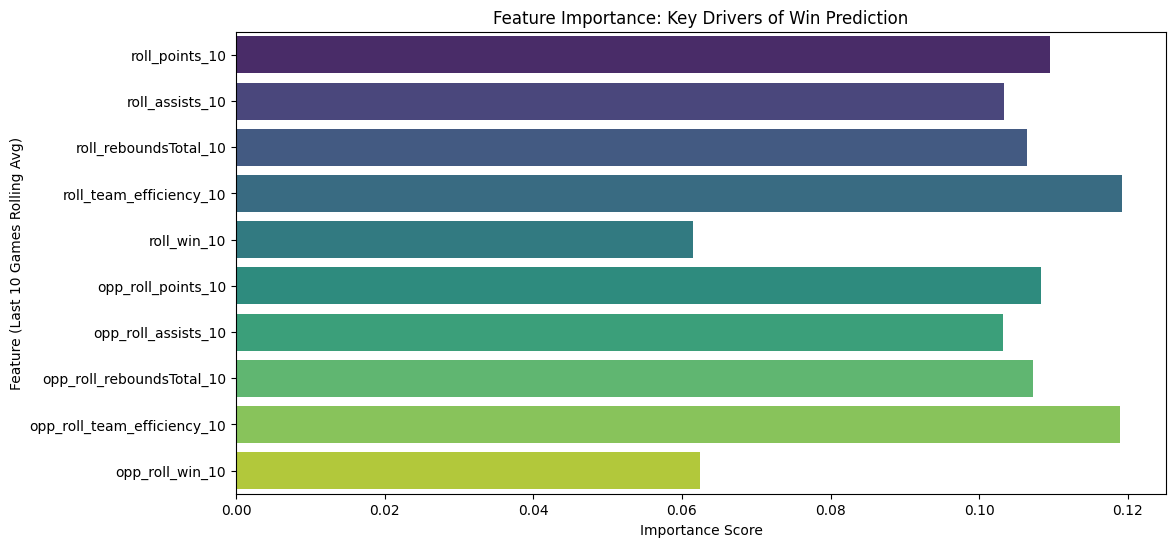

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

rf_model = stacking_model.named_estimators_['rf']
feature_names = [
    'roll_points_10', 'roll_assists_10', 'roll_reboundsTotal_10', 'roll_team_efficiency_10', 'roll_win_10',
    'opp_roll_points_10', 'opp_roll_assists_10', 'opp_roll_reboundsTotal_10', 'opp_roll_team_efficiency_10', 'opp_roll_win_10'
]
importances = rf_model.feature_importances_

plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title('Feature Importance: Key Drivers of Win Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature (Last 10 Games Rolling Avg)')
plt.show()